# 病理切片全扫描图片(svs)的读取和显示
## 由于每张WSI(Whole-slide Image)的病理切片图一般都是在几百M到几G不等，原图可达几万×几万像素的大小，因此无法直接在python中用常规的图像读取方法进行处理。对于这种病理切片图片，一般都会用openslide进行读取，使用openslide可以快速实现图片指定区域的切片提取，以及还原金字塔构建和生成titles。下面简单介绍python中openslide读取svs图片的常用处理方法。
## by Kwong

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import openslide as opsl
import sys
# sys.path.append('/cptjack/totem/Colon Pathology/svslabel')

In [2]:
slide=opsl.OpenSlide('/cptjack/totem/Colon Pathology/IMG/18686_.svs')
#根据路径读取svs图片
level_count = slide.level_count  
print ('level_count = ',level_count)
#level_count属性是该svs图片有多少层金字塔结构，本例是四个

level_count =  4


## 所谓的金字塔结构，就是svs图片已经存储了从上到下每一层采样的图titles，就上面的例子而言，该svs图片共有四层图像。默认情况下0级是原图，每向下一级相当于是对上一级图像的一个下采样，下采样比例一般是4，也可以是2。可以通过下面的语句快速知道每一层图像的大小以及其下采样的比例。

In [3]:
Wh = np.zeros((len(slide.level_dimensions),2))
#level_dimensions属性是获取指定级下的图像的宽和高，返回的是一个list，每一个元素是一个数组
for i in range (len(slide.level_dimensions)):
    print('level_dimensions: ' + str(i))
    Wh[i,:] = slide.level_dimensions[i]
    print ('W = %d, H = %d'  % (Wh[i,0],Wh[i,1]))
    
Ds = np.zeros((len(slide.level_downsamples),2))
#level_downsamples属性返回的是指定级别下的下采样比例，需要注意的是这个数字表示对0级图像的下采样倍数。
#get_best_level_for_downsample属性是接收由求出的下采样比例的数值返回的对于金字塔结构层数
# 上述属性返回的同样是一个list，每一个元素是一个数组。
for i in range (len(slide.level_downsamples)):
    Ds[i,0] = slide.level_downsamples[i]
    Ds[i,1] = slide.get_best_level_for_downsample(Ds[i,0])
    print('%d of level_downsamples is %d : the best_level_for_downsample is %d ' % (i,Ds[i,0],Ds[i,1]))

level_dimensions: 0
W = 77687, H = 39682
level_dimensions: 1
W = 19421, H = 9920
level_dimensions: 2
W = 4855, H = 2480
level_dimensions: 3
W = 2427, H = 1240
0 of level_downsamples is 1 : the best_level_for_downsample is 0 
1 of level_downsamples is 4 : the best_level_for_downsample is 1 
2 of level_downsamples is 16 : the best_level_for_downsample is 2 
3 of level_downsamples is 32 : the best_level_for_downsample is 3 


## 由运行结果可知，本例的svs图片0级下(即原图)的大小是77687×39682，其中每向下一级就相当于以1/4的比例下采样一次，到最后的3级下，图像只有2427×1240。需要注意的是，不同svs图像其level_downsamples属性返回list不总是一样，而且实际上每一个数值并非刚好是整数，不过实际处理中可以转为int处理。

In [4]:
print(slide.level_downsamples)

(1.0, 4.000178042433282, 16.001124132088634, 32.00554481172827)


## 在opensilde中提取图像有两种方法，分别是get_thumbnail和read_region。get_thumbnail是根据你指定的尺寸，返回原图的缩略图；read_region提取指定层数下指定起始位置和大小的切片截图。在对0层图像(即原图)进行采样和处理中，read_region更常用。

(4855, 2480)


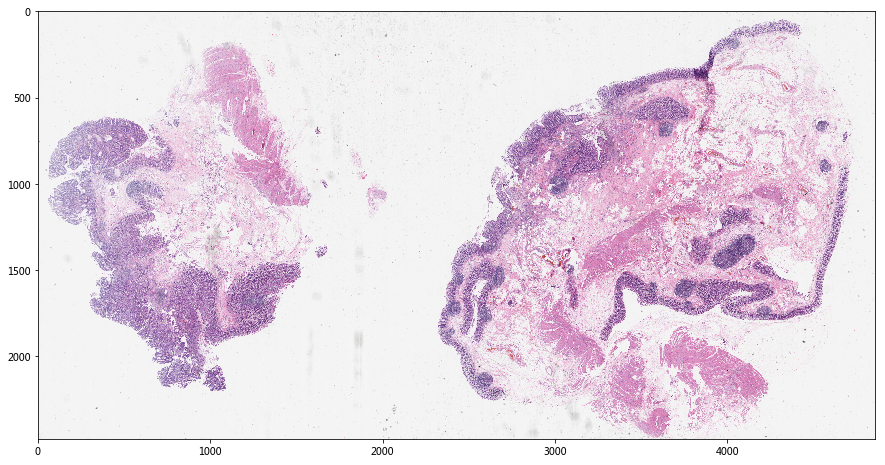

In [5]:
plt.rcParams['figure.figsize'] = 15, 15
slide_thumbnail = slide.get_thumbnail(slide.level_dimensions[2]) 
# 以2级图像的尺寸作为指定输出的缩略图尺寸返回一个缩略图图像
plt.imshow(slide_thumbnail)
print(slide_thumbnail.size)

(1200, 613)


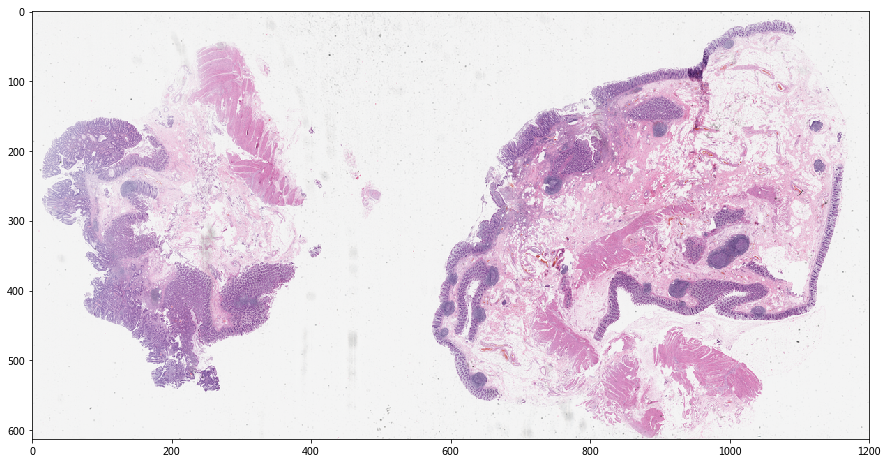

In [6]:
slide_thumbnail = slide.get_thumbnail((1200,613)) 
plt.imshow(slide_thumbnail)
# 也可以自己指定一个具体的数值，需要注意的是，第一个参数实际上代表的是宽W，第二个参数代表的是高H
print(slide_thumbnail.size)

(1024, 512)


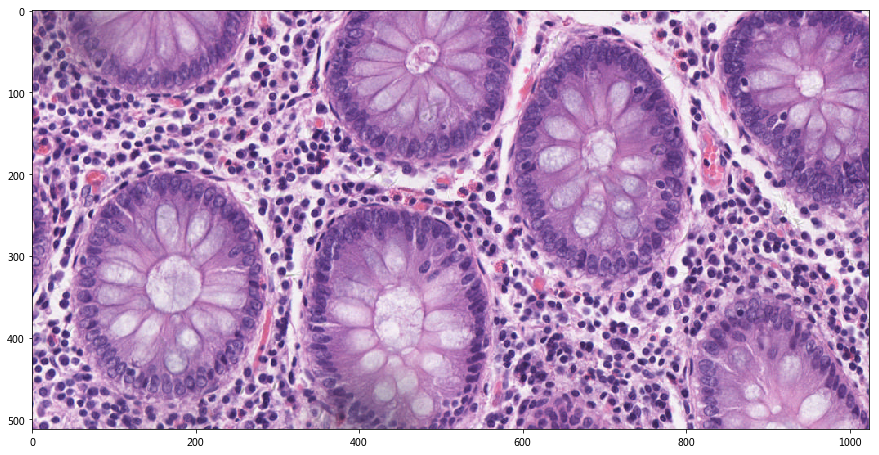

In [7]:
tiles = slide.read_region((16000,30000),0, (1024,512))
# read_region方法有三组参数，第一组参数是你要提取切片的起始坐标(该坐标是对应曾经下的坐标)，第二组参数是你要提取的图像层级
#  第三组参数是切片的尺寸，同样是(宽，高)的形式
plt.imshow(tiles)
print(tiles.size)

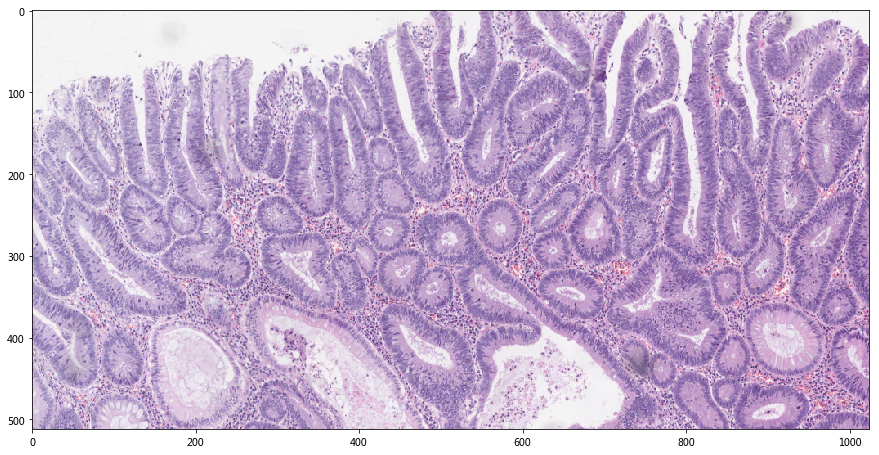

In [8]:
tiles = slide.read_region((4000,9900),1, (1024,512))
# 这次是在1级图像下进行提取
plt.imshow(tiles)

## 需要注意的是，不论是get_thumbnail还是read_region，二者返回的都是python的图像对象，如果需要用别的图像处理工具进行后续的图像处理，比如skimage或opencv，都需要先将其转为numpy格式

In [9]:
print(type(slide_thumbnail),type(tiles))
# 用此方法返回的是RGBA的图像对象
tiles_n = np.array(tiles)
print(type(tiles_n),tiles_n.shape)
# 因为返回的图像是RGBA的格式，所以转成numpy时有4个通道，实际上我们的处理只需要前三个通道(r,g,b),所以可以做进一步的筛选
#  在不需要显示切片图像的情况下，建议一步到位完成提取和转换
tiles_n = np.array(slide.read_region((4000,9900),1, (1024,512)))[:,:,0:3]
print(tiles_n.shape)

<class 'PIL.Image.Image'> <class 'PIL.Image.Image'>
<class 'numpy.ndarray'> (512, 1024, 4)
(512, 1024, 3)


## 通常我们要对一张全扫描病理切片图像进行处理分析，都是在预设切片截图的尺寸和在移动步幅下，以循环的形式完成所有切片图像的读取和处理，下面给出这种思路下的demo

In [ ]:
def(slide,patch_c,patch_r,step):
# patch_c,patch_r分别是切片图像的宽和高
# step是移动的步幅
    slide.level_dimensions[0]
    w_count = int(slide.level_dimensions[0][0] // step)
    h_count = int(slide.level_dimensions[0][1] // step)
    for x in range (1,w_count - 1):
        #一般来说头和尾的部分都是空白，可以适当跳过，当然也可以选择全部处理
        for y in range (int(h_count)):
            slide_region = np.array(slide.read_region((x * step , y * step) , 0 , 
                                                      (patch_c,patch_r)))[:,:,0:3]
            ## 这样得到切片图slide_region对象后，可以开始下一步骤(保存或者处理分析)

In [10]:
slide.close()
# 当处理完毕之后，调用close()方法以释放内存